In [1]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        # q = 1-p_dropout
        # u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_in + (hz * (hh - h_in))
        # equal to
        # h = (1.0 - hz) * h_in + hz * hh
        # or
        # h = h_in + (hz * hh)
        # or
        # h = h_in + hz
        # or
        # h = h_in + hh

        # SELU + SELU-Dropout
        y, y_cache = l.fc_forward(h, Wy, by)
        y, y_selu_cache = self.selu_forward(y)
        y = X_in + y
        
        if train: # with Dropout
            y, y_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache)
        else: # no Dropout: testing or validation
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache)

        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache = cache
            dy = self.alpha_dropout_bwd(dout=dy, cache=y_do_cache)
        else:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache = cache
        
        dy_out = dy.copy()
        dh_out = dh.copy()
        
        dy = self.selu_backward(dy, y_selu_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        
        dh += dh_out
        dh_in1 = dh * (1.0 - hz) # res

        dhh =  dh * hz
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dhz = dh * (hh - h_in)
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dX = dXz + dXh
        
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2 # res cells
        
        dX = dX[:, self.H:]
        dX += dy_out # res layers

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t], train=True)                
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                sample = self.test(X_mini[0], state, size=100)
                print(sample)

Iter-10 loss: 110.6712
enwwwh日mli i  esaioohh  sa    ,reenstmp9 hdgnb hettn  sahayrnp eo mae ad rawzepatnn  e Ugtuioereeprsa
Iter-20 loss: 102.4333
eE2Dshls epeeedaane oo  ra.  tp1niiihcadtreytrP;ie htaee–"o% tiuooo tm m s tuoooipraRroo uhdeho lina.
Iter-30 loss: 103.8332
eFcf bWriKSosJ toedho eppaato  otmee an6 he  reac, n poo  oo JJlsd Badan   u  ,nsbw tene  rn iigel.s 
Iter-40 loss: 103.7657
egp.sFatipJbe WaedSoe d lecopDieme2llJ mtlfce
pptoilorndpe   ra nius  eralteu
  ntvl.inyiu esaast bob
Iter-50 loss: 108.2371
e5l8yut.y Jtd,phn uwcvceths hhcrs r日lgh c p i t  at eeemodd orep4e prnaoHummpar oRondddalanoututdr(ta
Iter-60 loss: 102.3077
e–dfgf–eIpea iio d uld 5angto  ohud thiroitteeets(aCoJya9is loy acn "ir in ler kog ttterlattiae sr,ot
Iter-70 loss: 97.3487
e(J2ninnO a3georae or uo rfh ;e ger1t eanees oxCinai-h  if,mhr"u. onh  a  hK本ieyrnntsdeat daid w本e日 c
Iter-80 loss: 103.5549
eJifWn0innc 1pee ofhe ori oite o,rit mheromt rSin peHpeauud hp wenlxa es Ot–kan-pd iftln日 ziiin ryke 
I

Iter-670 loss: 63.6700
e1 thi0 pand In mainnt5 fiomilldin resthimy ard Japan in , 5an's alan isthe outlead the ald d indothe
Iter-680 loss: 62.1672
ed 4xt vopertav mellorothiis Garer and the Nop8rr cointh famhed ofx Ej本rns T eanofe th thenflof Nrora
Iter-690 loss: 61.2393
expertary str ofithith gestoS tneWse trel rt bolleand Japanas swNiten Wudbd led Krveokagvcclionte per
Iter-700 loss: 56.0471
e 47th uoutery in th- Weatg , an wepers and;. Therctas tion Iides dored py Sfo hoped lome and Rwis. C
Iter-710 loss: 65.5352
e ta-lerulal pirlen pirllokeogndited wor:sud Japanind sita andd Cons (ceanl Japan ins in Japand is se
Iter-720 loss: 65.3979
extmrinte %ich estiritex witan Wis and meitene Japanchis 本ihe, mf ri-ra3 on the Rwan's as ompiorea es
Iter-730 loss: 55.1495
ed at es ar pokwa nd ciintrSenkii  Warntut opey-lf ereleurle ph Japand ur G45O es as paca and no heve
Iter-740 loss: 67.2422
ent. Japan in  arEJspanewoo Japanesy Wand Wand8. 0Spccaforllly llur本ao -outony Nhe Sanj8 ;han yy,sthi


Iter-1330 loss: 48.7347
eghiig purrr an Wis lares a( Pnalar miort 2uChHintis wionte Eart. The GEEasem. Dbertres bomed in ahis
Iter-1340 loss: 45.9140
eChin margesta trocean Degolat Huciankiy s rostenpapatefrler ar arce ail3 onm9the watves an B asld Th
Iter-1350 loss: 59.0335
egwo4t rs intions. Obctpes thesh irod s-Japaneges ahe world's tertho and ea, frittinje tris dm orles.
Iter-1360 loss: 42.1165
en and Searo-iencean Ped bod Rusa an inhs arlata laliua the towFrw toe and io nora, in firstan rthin 
Iter-1370 loss: 39.3461
e. chllerc9a  orwin whith is didiN powctucin. The Too anxis ardedyored and Wa  arly a, c, the cerHed 
Iter-1380 loss: 32.8634
e. of the Me sive) an orlarest. Trerertu penthe wor4 ch Ind NNapare, sh OEhox3G, dnd Tok ourlaunt in 
Iter-1390 loss: 33.4575
eg miturpey witt anand fivo and follec日in-largpea wstx5e prle Niathoue ,-Japan thes zHd lirase SunkD,
Iter-1400 loss: 47.3185
ed Empetorl mg teves par e0a7d Chinstandevendes inKory. FroD Wer are sthicg orpes re poper. Uh

Iter-1990 loss: 23.3141
exthe sutme oured in stureal of 1 re 12, the sumised fomboteon the Sins aidedas Topeann kokliteat mxi
Iter-2000 loss: 29.9775
e1 m2 Japan has The coff. brranfeuntye Witn m an preitzon chint un rapente Sint miurterino aed it anl
Iter-2010 loss: 39.7319
en chake 0t maunty, in NiFEC9 Japonigis the iola iouna Smino,itovec the corlt"-la andirente nfred the
Iter-2020 loss: 32.8770
ed ind Emse forse thi chand of the woul pemsurthi andes  fopar es(mevy pur h89Un hase tounten Ts Japa
Iter-2030 loss: 38.2673
ex Japan is a houh countUe nt pricest mbirea. T6ernenwia don. Japan 1ish aWms and laggotan ,, firctar
Iter-2040 loss: 28.8623
en bard Hith s rcoplire fed intith cwestzeE prles an %tsiras tares and iag exper es the Rupan is unic
Iter-2050 loss: 34.7614
ed Emperom Lest mountevino a Kous ar hish is ander agest. Japane a6 Efleth lake ga the G Diantatae en
Iter-2060 loss: 39.5395
es and poflorily ix awdiled matoy llomilt ureed fith se Sin the Empare maliturtecinnledi
ankes

Iter-2650 loss: 19.1756
e worldef Corle fvured ingd Japane ma Snite isintron ea. Tn: Seand iont1 me Nipulihy Tn "osntryu, rar
Iter-2660 loss: 22.9845
e) of the Uxps terion miceteryis, tol thr IP-leot of inoI d5in, the country wist 2xisnteroT enI ar an
Iter-2670 loss: 32.0789
en the Seat of secons lered 1ath of toUad in apan ter;pretsllteviner ppentho pertP inal counopye mal.
Iter-2680 loss: 25.8135
eChine and aillof JapaniRessI wored fimated nilg meferHHes an"upentropin" tor as and oiule–Deengint c
Iter-2690 loss: 39.8764
e tored 3id RhighS Iid The Tarmo Anding omd miprea at inat In (JakanoDi gevoverlly wite plrEmpe orol 
Iter-2700 loss: 29.2357
eko-Japan'sn ancetforse war Oupor-Naresil orlithe Upilter angrea, twed of 1sre inomed. Tho chaper as 
Iter-2710 loss: 18.9897
ec1ure ssolapan toundry ns arandela ofitheunereabed of the noun. Apexcaron tho Holity- ar .a. The Jap
Iter-2720 loss: 24.1966
ed itgve cond silgea a derFeopar Rapan ins iacateon the cars ofe mFimthe pla9eo n, ma tio Kex,

Iter-3310 loss: 36.4969
e world's torte tegitst ai westocllitotur an is  mpar estarh s tivive arges and Hficaryys nfeis tHrus
Iter-3320 loss: 20.8320
en aris aidh t minatomy ith o marectid carna wint miinterio'n Eald Statec fechtre parlediKy cpurlloum
Iter-3330 loss: 27.5580
ed lored 20 the nftctuped logonat CuufeWor as and Westory indDs redllive a deviogst arectar GEusalatx
Iter-3340 loss: 24.4273
expaj mowat ro Tacdtotyes fouct ecoly.17945,, mllitith perged toecoF. ftud NatDs legit t wectrof of J
Iter-3350 loss: 17.0796
ed inBracknd in perced 5f Japan's timy rr)eMacd if ahechicanges ia the e wodH anes tho amdest ofed co
Iter-3360 loss: 21.1302
e torBdan Gosiand Hindkbiry in thUbsed sldesud erupeaten ised forones ind ou2theand lige a9me tiry sh
Iter-3370 loss: 26.5989
expar e)mir to, 1937 Nestiind. brofctrcane tiving anderend Neseopaoc an 2uursed ni-s rethe turyd War 
Iter-3380 loss: 31.3757
ed intry Ningpan Em. Hor audes initaky 4, inchtho esta mestgectooy . mectteviol N peofllerys m

Iter-3970 loss: 33.3273
en aNmerio meenocinveured and teand unsth nwtorse turo clan ursilsoun ururoh in un hiso-tarn shg ctre
Iter-3980 loss: 20.1545
etcone tor estirGaly ithRudsleKWaaw ctre6,f mien pemper ecpioe dHea end ne1spo s an exparn la th- a本u
Iter-3990 loss: 21.8101
ed and Wi4lerhised marteving and ranke in Cound Sinsty Japaninas and insuresl-oirod 191, es anded Jap
Iter-4000 loss: 22.4829
ed it9d. The wors and ithlGeAsanlorn mheloboly Japan (Japan" is –owso mi
. AsuCh nins af en prealloun
Iter-4010 loss: 15.0647
echisl beed divellboled Se%oun ehuldes ina the war, thith- aFg1st  andigkr pocthinion shonthltho er a
Iter-4020 loss: 20.7455
ec7Kompected is ofe01h c anCHtoilat Sea Si'n the eorld st Japan s本F mittoy ichistd Japanican ma ofiin
Iter-4030 loss: 14.1179
enf urtes and Wealer, acctionlobe, chichkges farrtel. Aructhingicy prte of trols cetotuvens as onLan 
Iter-4040 loss: 22.9555
ed of zo- 1933. Ianke oficere–des of tioulesing foreren ig tze  andsl. Tho crpat e wirndB ande

Iter-4630 loss: 25.5342
e torpect of ing1853 1本 a;and canker in oi0th ianaO outed ingle
. "Gensured in the Globi1 t, whe rosl
Iter-4640 loss: 21.7481
eWto toly crant. destoN, pert d arvesRa, pancexp6rilelly. marre porcelinMo fbume ekper and xia Simico
Iter-4650 loss: 29.5141
end in 1945 Japan, The nTo. Cs.umion perisiln mifitirFes thea lelad cofel: umperteri(Wof of Japan, 5s
Iter-4660 loss: 30.7591
ed first in the numivelops i:ctrea, 本ontun isha wolatemaiky upex ans tajigstte insterpan w's revere m
Iter-4670 loss: 34.7105
ed fecpoped laggestarU fothe f (Jlpan'se wist Jfpan is.iElin 1s leand ingje Cs dedecengercecM of ond 
Iter-4680 loss: 13.6489
e porchina seacandera ompantero7o to1 th zen Japan's aAstitovoler本pain as cinol7, miintominitaligeng 
Iter-4690 loss: 21.7037
e-Eapeed peroe tar osallowy trom andexc nalerrpal cruf 186e ponts tivinglatse fitst onte marlef th th
Iter-4700 loss: 30.6898
ec intren la
. Ind Shanan iChiredid ges as mborteri ll9ro tint oxeatofe simater aian ur highe 

Iter-5290 loss: 12.1863
e fourty 2h wonI at of Empethe male pharec iolstecJapanied ande wall prea lnte East ot rekio ana the 
Iter-5300 loss: 12.3032
e torNd Sins veBPankig as cJapan es inh0 rpueation pionteKyu, n, whc ropuril aga5 tar ssa oi t exparn
Iter-5310 loss: 19.7203
exper touts aerrigcy rTo pounhDiI fCrinese maromint iJapaniie woiT. Noknon C0ifeRupand a–les an peown
Iter-5320 loss: 13.0903
ed of 1268, tnlD citht PeceLaud iaUdsk   parolatye0te malyiot of in aslu, wis the 12u 3ar esia, in 5a
Iter-5330 loss: 17.4852
ed of 12853 1 the weg of in%lo 6obo, ta toy ans the combtoy wh hirtors cith is the howes maMe of Nkho
Iter-5340 loss: 31.8614
ed i日ta. The. Tex ana, Ia theihosl bo, th the lored come6,con mivitar Ts if tiothe NaGde Anes f omver
Iter-5350 loss: 23.0678
en the wirt oDllombto ses mabile a"apan
tjied the "stInd of 1,ve aJceae 1u, aa) os anec, in in 19de f
Iter-5360 loss: 16.9298
e porl–centuriOlyuiS of HirsPa 2fontola, ton Ebrl ollan ch atNo and the worl sigNitte terowol 

Iter-5950 loss: 21.3495
enturnecticnPfiea tyulamped iog%s% gh ytstecppethrignat erledind s%as  orve grout cy botexpind pWrce 
Iter-5960 loss: 14.8852
ed Japan in 1947 me%0og or7l aakMoin if tivas xunturiestag 1oto anded ingha aB anata in a) th esed of
Iter-5970 loss: 12.5931
e forured in os aben  is arleo, 'f colestean eesed Jsean iogintd I3a Seaio, the candino dicingAding,c
Iter-5980 loss: 22.6353
e forzer an45y ard Wag Nigastyes chanc areBoand ton 0sh bingwa kiRtsin bilg cria pemionten isod ;ilut
Iter-5990 loss: 17.6611
ed first in the numbered. The Emperter log"oty of Japan ins vurida, womart
.e Emst ersaoI omr.3i Taiw
Iter-6000 loss: 19.1634
ee (miryAigh the d2lides om intcinsl Comy. Aspainhalero th Chu-d rysc. Japane es onuts aigotjres an e
Iter-6010 loss: 11.4587
e7thinecf esven Ky pourtaky "s if tromslFiot the Eatt on;earneed norse n-makanes o andoended neggestr
Iter-6020 loss: 17.8807
eKoupan estarcecxan porldec, Japan is azze malloos 's. Tokad figsets 
. The h ur earl of the h

Iter-6610 loss: 10.8123
ea of Japan hish frof crlat) le onat HunarlaB wit roOleaness ingherse Sured into a5 mity :h tarncflin
Iter-6620 loss: 11.3595
ed forsoke th  arKot  ny 28, tan in is ad ongisad miontuin aivol iouloteme nous profored日i PaNiogig. 
Iter-6630 loss: 17.1780
e日t in5cine pounzio im(fioo lats usedturidol timth Kouna larkedif of in6rKye wnd reeko-%odA, as UsbeH
Iter-6640 loss: 29.6094
ed Japan in 1947l Japan ios miko, if ci'sed. Apeailotitaa of incegeollo9. kae Siaiof in the worHL本 Th
Iter-6650 loss: 18.0396
e nor01853 waknowa" tarla, which pe8jo stding trsed War asaun 0th cisiot of exginFla tes if the 18 Se
Iter-6660 loss: 10.6726
expor tola, Honazeo Japangig ax perfed foper alBronat4o largalt ciRalan pse sorlo's cing proppea o Ie
Iter-6670 loss: 21.2563
e fourtre sigapaM Wes a%mint本 AiinCtio noppencerien Jspan tse EastuCiin, Kores and the alu0th cilntry
Iter-6680 loss: 23.1815
expze toGldez, trestxrth intHurshinekwh live pboled in the countre olaA is ardithg ant r anden

Iter-7270 loss: 21.7256
e norSbate of ath 0e War esl 9jh on%ls Japandes anded itso and rogKrured aSen is atoilyboun ch oulare
Iter-7280 loss: 22.0069
e torPL-nandesegeopal citrSen The TaayiD highoth- argesta Imine popAopi;xur palicea, Cor8asionand ith
Iter-7290 loss: 21.1992
er of Wrol) inho h uh perleEvint t–iOlestert ol tion of ind sou1sta angitad Westo unecpaoB and Hounar
Iter-7300 loss: 27.9198
eR;par etprUe h re tan 8 Ind If eseleryarc wato omalme4, pmiotoonbin ch aanced ntres and tealetiOn ma
Iter-7310 loss: 28.4091
ecturino, an coparl of9town. Ihand Seatou, which pheserEmi"Oy am, in 4rupin is the Chind ors . The co
Iter-7320 loss: 20.3860
ed in71 ry cntething loseran in, Empe oryh as Wes of Chif es Japan es 7istory in tioos inho h ist2r a
Iter-7330 loss: 20.5387
ed first in the number of "hwis le(cad loges.ai til)out rcesoe日. The figr8gs and Wer hwar of and Hoar
Iter-7340 loss: 22.9583
e norfrcd esvon paoled ixth lanacdand ef re6,s.ain, the worly's targestar Tokad in 1945 mentio

Iter-7930 loss: 9.2703
ed first in the number of Nobel laureat6oin lIy72 98h. Toky uper prres. tho, ma-kion PTI oendine the 
Iter-7940 loss: 9.2194
e porimal DeveH umA20,awand is an", thicen Jspan, aBsin
. Chek%Upied and tante tiLang on the Senturen
Iter-7950 loss: 19.7418
ed first in the n:ur colollefjit of early s undecleo". fro日 tye Pangima bymive flur9s. CSun" in6liri 
Iter-7960 loss: 12.8617
e Emperoperecoid "Stas iAstar Tveroesty ch omaioe the Ta. Ch.ion-teryj9 Sta if ithoiges , urthrecclli
Iter-7970 loss: 20.7456
er(cinnduys wivRrary end Nixpon the Pangico friont本 and 6, tho teFi6 the and fiar eWmal EustWesnomale
Iter-7980 loss: 28.3286
e torDe toWze tsopeHc, crth uillor6 1, t1 watory prdoch rcomeSla, if aite4thistou8. urpcrnalityix, to
Iter-7990 loss: 17.5659
econ9ty ".xthe Empare anar arlalandhearcounald ingsoP8 npur ar hWtUG, Ts4at oo Wec, regilatB andk ore
Iter-8000 loss: 18.9771
e torWest6 oneAAsian NJapan") is anIvil"Din timy Japan cand which ousura's in theAcoflobo stan o

Iter-8590 loss: 13.4726
e4ulimeno alaate". A pOreseting powan: . Japand an e28ar colmetred Nhead West ronaldenci0a tor
. In c
Iter-8600 loss: 22.0986
e torAdiand I ved本3U Nsliontupeckeou% ca ofotho and 
. Nipponio. Japan's Ug hise Gullareasif conompee
Iter-8610 loss: 8.6033
ed first in the Ciunt onslame of 186, inlJtys nowh sOKeoth cenduri4g vivis. Locats in tirsedolotMea, 
Iter-8620 loss: 8.2566
ed and wMicMecony Pa ana the world's fichterles ffor omlHcome. ofole4ci–s oKoAs asmon% bom and HoTai 
Iter-8630 loss: 8.5235
e world's largest lrte thM Rusido, Kyuwirthisndigntte ai%bot tict eUper wBst ore, and RGwstatI In a;p
Iter-8640 loss: 13.0230
ed first in the number of Nobent weMe chisertdoingig–str and revee liog snrthean of". Iroilisy ficI a
Iter-8650 loss: 8.5598
e tory ctmeiolopincowion Asian Chinand anderopte eno palacona6 CEmio truper an the countre os dbou p3
Iter-8660 loss: 8.2433
e world's lorrlst mbinterinnturioe 本is, imBlare starecHty ehvfles ea tLaresd. rorld h Brons 5menter

Iter-9250 loss: 13.1960
e nor2h SeR3aCO ingioz18 Siand ioInd Seckeuil EficLar lililltio n1mjI Japan, and toitan Swai5 Is enri
Iter-9260 loss: 17.4873
e torgnct en,zu  omesko In the oKyl8pu
. An–sho 8idived ul lestoknyicinomixe ciihtit)) istlefeyd porl
Iter-9270 loss: 12.7702
e Pald0io a% ot ofil, Th roxNdh Japan tes 2umpen, of Japan is5a mencepeIJapang and fianted ande parej
Iter-9280 loss: 7.9346
econ. Asith N本 ann"stal P%ysi nesh porseit an soit1 un Japaniud War UnstrocG ofobor 's teopod lare an
Iter-9290 loss: 19.6619
e world's largest mehCd Sexoun. Siand io thrirc0Larn liggran esuliont r The wowid3s y Tar Tomyary cpa
Iter-9300 loss: 14.4737
e Pallity tre sorCh.iI cKre日p icRaping as B(u6, Japan日it ines am6 it li
. In ixhh rt4lerellitely mafi
Iter-9310 loss: 12.0455
e world's latres latp aiar an,  anrs –nunUpcenocminto2 s; arome f's, orHkrowhos 8inoP aro日d Westd ing
Iter-9320 loss: 19.7031
er alFhith in the yjsidhS ax shr an peJapan ensidan ceicankey is ")"1 d, the world's thorc-part

Iter-9910 loss: 17.5927
e worlr's Kiog or Ns ofiD ho h an-estathe worh clion Ouran, whith in the ;prempurMe in or ingilysi fe
Iter-9920 loss: 17.0633
ed first in the number of Nobel laureates of anBrenllie) p earnnct nico-fer, vl) Eurld CDin in 1868 i
Iter-9930 loss: 17.2843
e world's largest metropo. Tak of itdlitDe and seberecowfo
. miG,Mic: tote to-seros 1 re miKllon 18hh
Iter-9940 loss: 12.7503
ed first in the number of "sblle purtajigesta Inkedeinto日s jouca mil,ritid itCo al of NMecontory itti
Iter-9950 loss: 15.8979
e Pal'olyobMd aistearnow% g toved ra te: inctheidesty bMte E"st rt日o ald,ita kTo colntriun t or e(pro
Iter-9960 loss: 13.2032
ed 19th NiFisKrod ando n revenB本an in  intO Ws日0i;pcirea, horhP and (MApenntrycin mircturigo, tPr o6 
Iter-9970 loss: 7.7703
eLosud,gict rurceauC本 9e. To no4% of i–sered. rod %as Gesaand of W
. seond zev Japan, on NGpano's ion
Iter-9980 loss: 16.5615
e norud bogso. mint ookeanin in ch"othos makecy sivenald Ttien5y brocoon Kit:sh can-s rigplite 

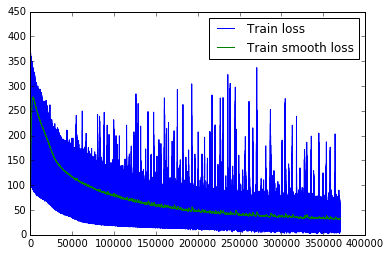

In [3]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()